This notebook contains some tools and techniques for doing data scraping.



##Easy cases##

It looks like many of the documents have tables already formatted. The following code is for those cases.

In [1]:
#The relevant library. Don't pip install camelot. It will ruin your environment. Instead install camelot-py and [cv] adds the computer vision dependency
#!pip install camelot-py[cv]


We're going to use one particular officer's file from 
https://www.minneapolismn.gov/resident-services/public-safety/police-public-safety/police-reports-and-data-requests/frequently-requested/critical-incidents/


In [2]:
import camelot
import pandas as pd

c:\Users\Jesse\anaconda3\envs\myenvname\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [3]:
#Change the name to the relevant downloaded pdf
pdf_path="Bauer_13.43-Privacy-Policy_Redacted_.pdf"

In [4]:
tables = camelot.read_pdf(pdf_path, pages='1', flavor='lattice')
#We take one page at a time.
df = tables[0].df

In [5]:
df.head()

0                   1   \
0                        Training Records                       
1                           Session Title  Training \nRecords   
2  2024 Engaging \nwith Minors- \nGroup 8        In-\nService   
3             2024 CIT Refresh- \nGroup 8                 CIT   
4    2024 SWAT - \nEntry Team - \nCycle 7                SWAT   

                      2                      3                  4     5   \
0                                                                          
1  Start Date \nAttended    End Date \nAttended  Total Hours Grade         
2  09/19/2024 \n12:00 PM  09/19/2024 \n09:00 PM            8 hours         
3  07/09/2024 \n12:00 PM  07/09/2024 \n09:00 PM            8 hours  Pass   
4  06/26/2024 \n08:00 AM  06/26/2024 \n04:00 PM            8 hours  Pass   

       6                 7                      8                  9   \
0                                                                       
1  Result  Salary Incentive  Certiﬁcate \nAttached  Completion \nDate   
2                        --                     No                      
3                        --                    Yes                      
4                        --                    Yes                      

                     10      11  
0                                
1  Date of \nExpiration  Status  
2                           N/A  
3                           N/A  
4                           N/A

If all goes well, this should look pretty good.

##Slightly tougher cases##

Let's try it with page 149 of the document.

In [6]:
tables = camelot.read_pdf(pdf_path, pages='149', flavor='lattice')
#We take one page at a time.
df = tables[0].df

In [7]:
df.head()

0  1  2             3   \
0                                             Course        Start \nDate   
1  2020 Annual Semi-\nAutomatic Handgun and \nGas...            1/8/2020   
2  2019 Annual In-Service \nTraining Program, Pha...                       
3  2019 Annual In-Service \nTraining Program, Pha...                       
4  2019 SWAT-Cycle  12-\nEntry Team Trng (Oct \nE...                       

                       4                       5   \
0              End \nDate                   Grade   
1                1/9/2020                    PASS   
2  11/19/2019  11/19/2019  Not \nApplicable  7.00   
3  11/18/2019  11/18/2019  Not \nApplicable  7.00   
4  10/23/2019  10/23/2019  Not \nApplicable  4.00   

                                6                     7  8           9   \
0  Continued \nEducation \nCredits  Instructor \nCredits     Make Model   
1                             1.00                                        
2                                                                         
3                                                                         
4                                                                         

           10  11  
0  Serial \n#  Cc  
1                  
2                  
3                  
4

Here, we see that the text is read, but is being misplaced. All that needs to be done is some splitting. Here are some helper functions that will aid us in parsing the text.

In [8]:
import re
def course_splitter(courses):
    parts = re.split(r'(?<=\))', courses)
    return parts
#We see that a couple of the classes are bunched up. However, it seems that all the classes end with a left parentheses, so this functions split along that.


def grade_splitter(passing):
    y=re.split(r'(?=\d)', passing, maxsplit=1)
    return y
#This should splitting up the passing score and the number of credit hours, since those two columns have also been mixed up.

def date_splitter(date):
    output=[]
    y=re.findall(r'\d{1,2}/\d{1,2}/\d{4}', date)
    if y:
        output.extend(y)
        return output
    else:
        return 0
#Some of the dates are bunched up as well, so we split that. Since we notice that there are quite a few blank cells, we'll enter 0 as a placeholder.



We start by cleaning up the dataframe, using the first row as the columns. Then we'll remove some empty columns.

In [12]:
drop_list=[]
for i,z in enumerate(df.columns):
    if (df[i]=="").sum()==len(df[i]):
        drop_list.append(i)
df1=df.drop(columns=drop_list)
#Let's drop the empty columns

df1.columns=df.iloc[0]
df1=df[1:]
#reset column index





KeyError: 0

In [15]:
#Now we can start breaking up the parts of the dataframe
#Let's extract the trainings
trainings_list=[]

for thing in df1["Course"]:
    if len(thing)>1:
        q=course_splitter(thing)
        
        trainings_list.extend(q)
str_list = list(filter(lambda x:len(x)>1, trainings_list))

In [ ]:
str_list
#We notice a stray date there. We will take care of that later
#First, we do some cleaning

In [17]:
new_trainings=[]
for s in str_list:
    w=s.replace(f"\n","")
    w=w.replace(f"Edit","")
    w=w.replace(f"Delete","")
    w=w.replace(f"  ", " ")
    new_trainings.append(w)

In [18]:
#We should have as many dates as we have trainings, so we instantiate an empty list
dates_list=[0]*len(new_trainings)

In [19]:
#Let's add that stray date
for i,z in enumerate(new_trainings):
    match=re.findall(r'\d{1,2}/\d{1,2}/\d{4}',z)
    if match:
        print(match)
        new_trainings[i]=z.replace(match[0],"")
        dates_list[i]=match[0]

['8/14/2019']


In [20]:
dates_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '8/14/2019', 0, 0]

In [21]:
df1["Start \nDate"]

1                                              1/8/2020
2                                                      
3                                                      
4                                                      
5                                                      
6                                             9/19/2019
7     9/17/2019 \n9/16/2019 \n9/15/2019 \n8/27/2019 ...
8                                                      
9                                                      
10                                                     
11                                                     
12                                                     
13                                                     
14                                                     
15                                                     
Name: Start \nDate, dtype: object

In [22]:
#We still see bunched up dates, so let's run a similar technique

new_date_list=dates_list
for i,w in enumerate(df1["Start \nDate"]):
    if w!="" and new_date_list[i]==0:
        print("success")
        q=date_splitter(w)
        new_date_list[i]=q[0]
        print(len(q))
        if len(q)>1:
            for t,u in enumerate(q):
                if len(u)>1:
                    new_date_list[i+t]=u 

success
1
success
1
success
8


In [24]:
df1["Start \nDate"]

1                                              1/8/2020
2                                                      
3                                                      
4                                                      
5                                                      
6                                             9/19/2019
7     9/17/2019 \n9/16/2019 \n9/15/2019 \n8/27/2019 ...
8                                                      
9                                                      
10                                                     
11                                                     
12                                                     
13                                                     
14                                                     
15                                                     
Name: Start \nDate, dtype: object

In [23]:
new_date_list

['1/8/2020',
 0,
 0,
 0,
 0,
 '9/19/2019',
 '9/17/2019',
 '9/16/2019',
 '9/15/2019',
 '8/27/2019',
 '8/26/2019',
 '8/1/2019',
 '7/31/2019',
 '7/30/2019',
 0]

It turns out this technique is not too great. However, one pattern we recognize is that all the dates are chronological, so what we can do is convert all our entries into datetime object and sort by date.

In [28]:
from datetime import datetime

date_str = '7/30/2019'
date_obj = datetime.strptime(date_str, '%m/%d/%Y').date()

print(date_obj)


2019-07-30


In [29]:
#Let's take a look at the end date column
df1["End \nDate"]

1                                              1/9/2020
2                                11/19/2019  11/19/2019
3                                11/18/2019  11/18/2019
4                                10/23/2019  10/23/2019
5                                10/22/2019  10/22/2019
6                                             9/19/2019
7     9/18/2019 \n9/ 16/2019 \n9/15/2019 \n8/27/2019...
8                                                      
9                                                      
10                                                     
11                                                     
12                                                     
13                                                     
14                                                     
15                                                     
Name: End \nDate, dtype: object

In [ ]:
end_date=[0]*len(new_trainings)
#Let's instantiate our end dates

end_dates=end_date
for i,w in enumerate(df1["End \nDate"]):
    if w!="" and end_dates[i]==0:
        print("success")
        q=date_splitter(w)
        if len(q)==1:
            end_dates[i]=q[0]
        print(len(q))
        if len(q)==2:
            if new_date_list[i-1]==0:
                new_date_list[i-1]=q[0]
                end_dates[i]=q[1]
        if len(q)>2:
            for t,u in enumerate(q):
                if len(u)>1:
                    end_dates[i+t]=u 
#Try to fill in the dates

success
1
success
2
success
2
success
2
success
2
success
1
success
8


In [31]:
end_dates

['1/9/2020',
 0,
 '11/18/2019',
 '10/23/2019',
 '10/22/2019',
 '9/19/2019',
 '9/18/2019',
 '9/15/2019',
 '8/27/2019',
 '8/26/2019',
 '8/14/2019',
 '8/1/2019',
 '7/31/2019',
 '7/30/2019',
 0]

In [32]:
new_date_list
#We got pretty close, but still not great

['1/8/2020',
 '11/18/2019',
 '10/23/2019',
 '10/22/2019',
 0,
 '9/19/2019',
 '9/17/2019',
 '9/16/2019',
 '9/15/2019',
 '8/27/2019',
 '8/26/2019',
 '8/1/2019',
 '7/31/2019',
 '7/30/2019',
 0]

##The hard case##

All of the above cases have been ones where we could select the text, and it looks like packages like camelot have done fairly well at parsing them, with the only issue being line detection in the second case.

We will now move onto a much more tricky case where none of the text is selectable.

In [ ]:
#!pip install pdfplumber

  Using cached pdfplumber-0.11.7-py3-none-any.whl.metadata (42 kB)
Using cached pdfplumber-0.11.7-py3-none-any.whl (60 kB)


In [ ]:
#We're going to try pyplumbr and tesseract
import pdfplumber

In [ ]:
pdf_path2="Redacted_.pdf"
#We attempt to extract from this pdf.

with pdfplumber.open(pdf_path2) as pdf:
    q=pdf.pages[6].extract_text()
    print(q)
#It turns out pdfplumber is note very effective at all, though does work with the above two cases.

1519020


In [ ]:
#!pip install pytesseract
#!pip install pdf2image

  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
Using cached pdf2image-1.17.0-py3-none-any.whl (11 kB)


In [49]:
#Let's try tesseract

from PIL import Image

import pytesseract

We're going to borrow some code posted at https://stackoverflow.com/questions/60754884/python-ocr-pytesseract-for-pdf

In [ ]:
import os
from pdf2image import convert_from_path

#We need this to add the tesseract to our path
#The tesseract can be downloaded online
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

filePath = pdf_path2
doc = convert_from_path(filePath)
path, fileName = os.path.split(filePath)
fileBaseName, fileExtension = os.path.splitext(fileName)

for page_number, page_data in enumerate(doc):
    if page_number==7:
        #txt = pytesseract.image_to_string(Image.fromarray(page_data)).encode("utf-8")
        txt = pytesseract.image_to_string(page_data).encode("utf-8")
        print("Page # {} - {}".format(str(page_number),txt))
#We'll try to scrape page 7

Page # 7 - b'WorkForce Director\n\n2019 SWAT-Cycle 08-\n\nAlpha, Bravo, Charlie,\n\nDelta Squads Trng (Jun\n25; Jul 02, 09, 16)\n\nNot\nApplicable]\n\nPage 3 of 8\n\n2019 SWAT-Cycle 08- Not\nEdit|Delete} 1280 Trng (Jun 24) _| 6/24/2019 | 6/24/2019 |Applicable| 4.00\n\n2019 Annual In-Service\nTraining Program, Phase\n\nNot\nEdit} Delete} 11, (Apr-Aug/Sep 25-26) | 6/11/2019 | 6/11/2019 |Applicable| 7,00\nr 2019 Annual In-Service\nTraining Program, Phase Not\nEdit/Delete] I, (Apr-Aug/Sep 25-26) | 6/10/2019 | 6/10/2019 |Applicable| 7.00\n2019 SWAT-Cycle 07-\nRifle Team Trng (Jun 0S-\n\nNot\n6/5/2019 | 6/6/2019 |Applicable| 16.00\n\nEdit 06)\n2019 SWAT-Cycle 07-\nAlpha, Bravo, Charlie, Delta\nSquads Trng (May 28, Not\nEdit] Delete} Jun 04, 11, 18) 5/28/2019 | 5/28/2019 |Applicable| 6.00\n\n2019 SWAT-Cycle 06-\n\n2019 SWAT-Cycle 06-\n\xe2\x80\x98Squads-7 Hr\nBreaching/Tools Re-Cert\n(Apr 30; May 07, 14 or\n\n21\n\nNot\nEdit] Delete|Rifle Team Trng (May 08)| 5/8/2019 | 5/8/2019 Applicable] 8.

The good news is that this information is legible and has been read. The main problem is that it isn't organized as a table. Let's try to use opencv's computer vision to add some bars.

In [ ]:
print(txt.decode("utf-8"))
#By itself, this isn't terrible, and does provide some information

WorkForce Director

2019 SWAT-Cycle 08-

Alpha, Bravo, Charlie,

Delta Squads Trng (Jun
25; Jul 02, 09, 16)

Not
Applicable]

Page 3 of 8

2019 SWAT-Cycle 08- Not
Edit|Delete} 1280 Trng (Jun 24) _| 6/24/2019 | 6/24/2019 |Applicable| 4.00

2019 Annual In-Service
Training Program, Phase

Not
Edit} Delete} 11, (Apr-Aug/Sep 25-26) | 6/11/2019 | 6/11/2019 |Applicable| 7,00
r 2019 Annual In-Service
Training Program, Phase Not
Edit/Delete] I, (Apr-Aug/Sep 25-26) | 6/10/2019 | 6/10/2019 |Applicable| 7.00
2019 SWAT-Cycle 07-
Rifle Team Trng (Jun 0S-

Not
6/5/2019 | 6/6/2019 |Applicable| 16.00

Edit 06)
2019 SWAT-Cycle 07-
Alpha, Bravo, Charlie, Delta
Squads Trng (May 28, Not
Edit] Delete} Jun 04, 11, 18) 5/28/2019 | 5/28/2019 |Applicable| 6.00

2019 SWAT-Cycle 06-

2019 SWAT-Cycle 06-
‘Squads-7 Hr
Breaching/Tools Re-Cert
(Apr 30; May 07, 14 or

21

Not
Edit] Delete|Rifle Team Trng (May 08)| 5/8/2019 | 5/8/2019 Applicable] 8.00

‘a F

Not
Edit|Delete| ) 5/7/2019 | 5/7/2019 |Applicable| 7.00
2019

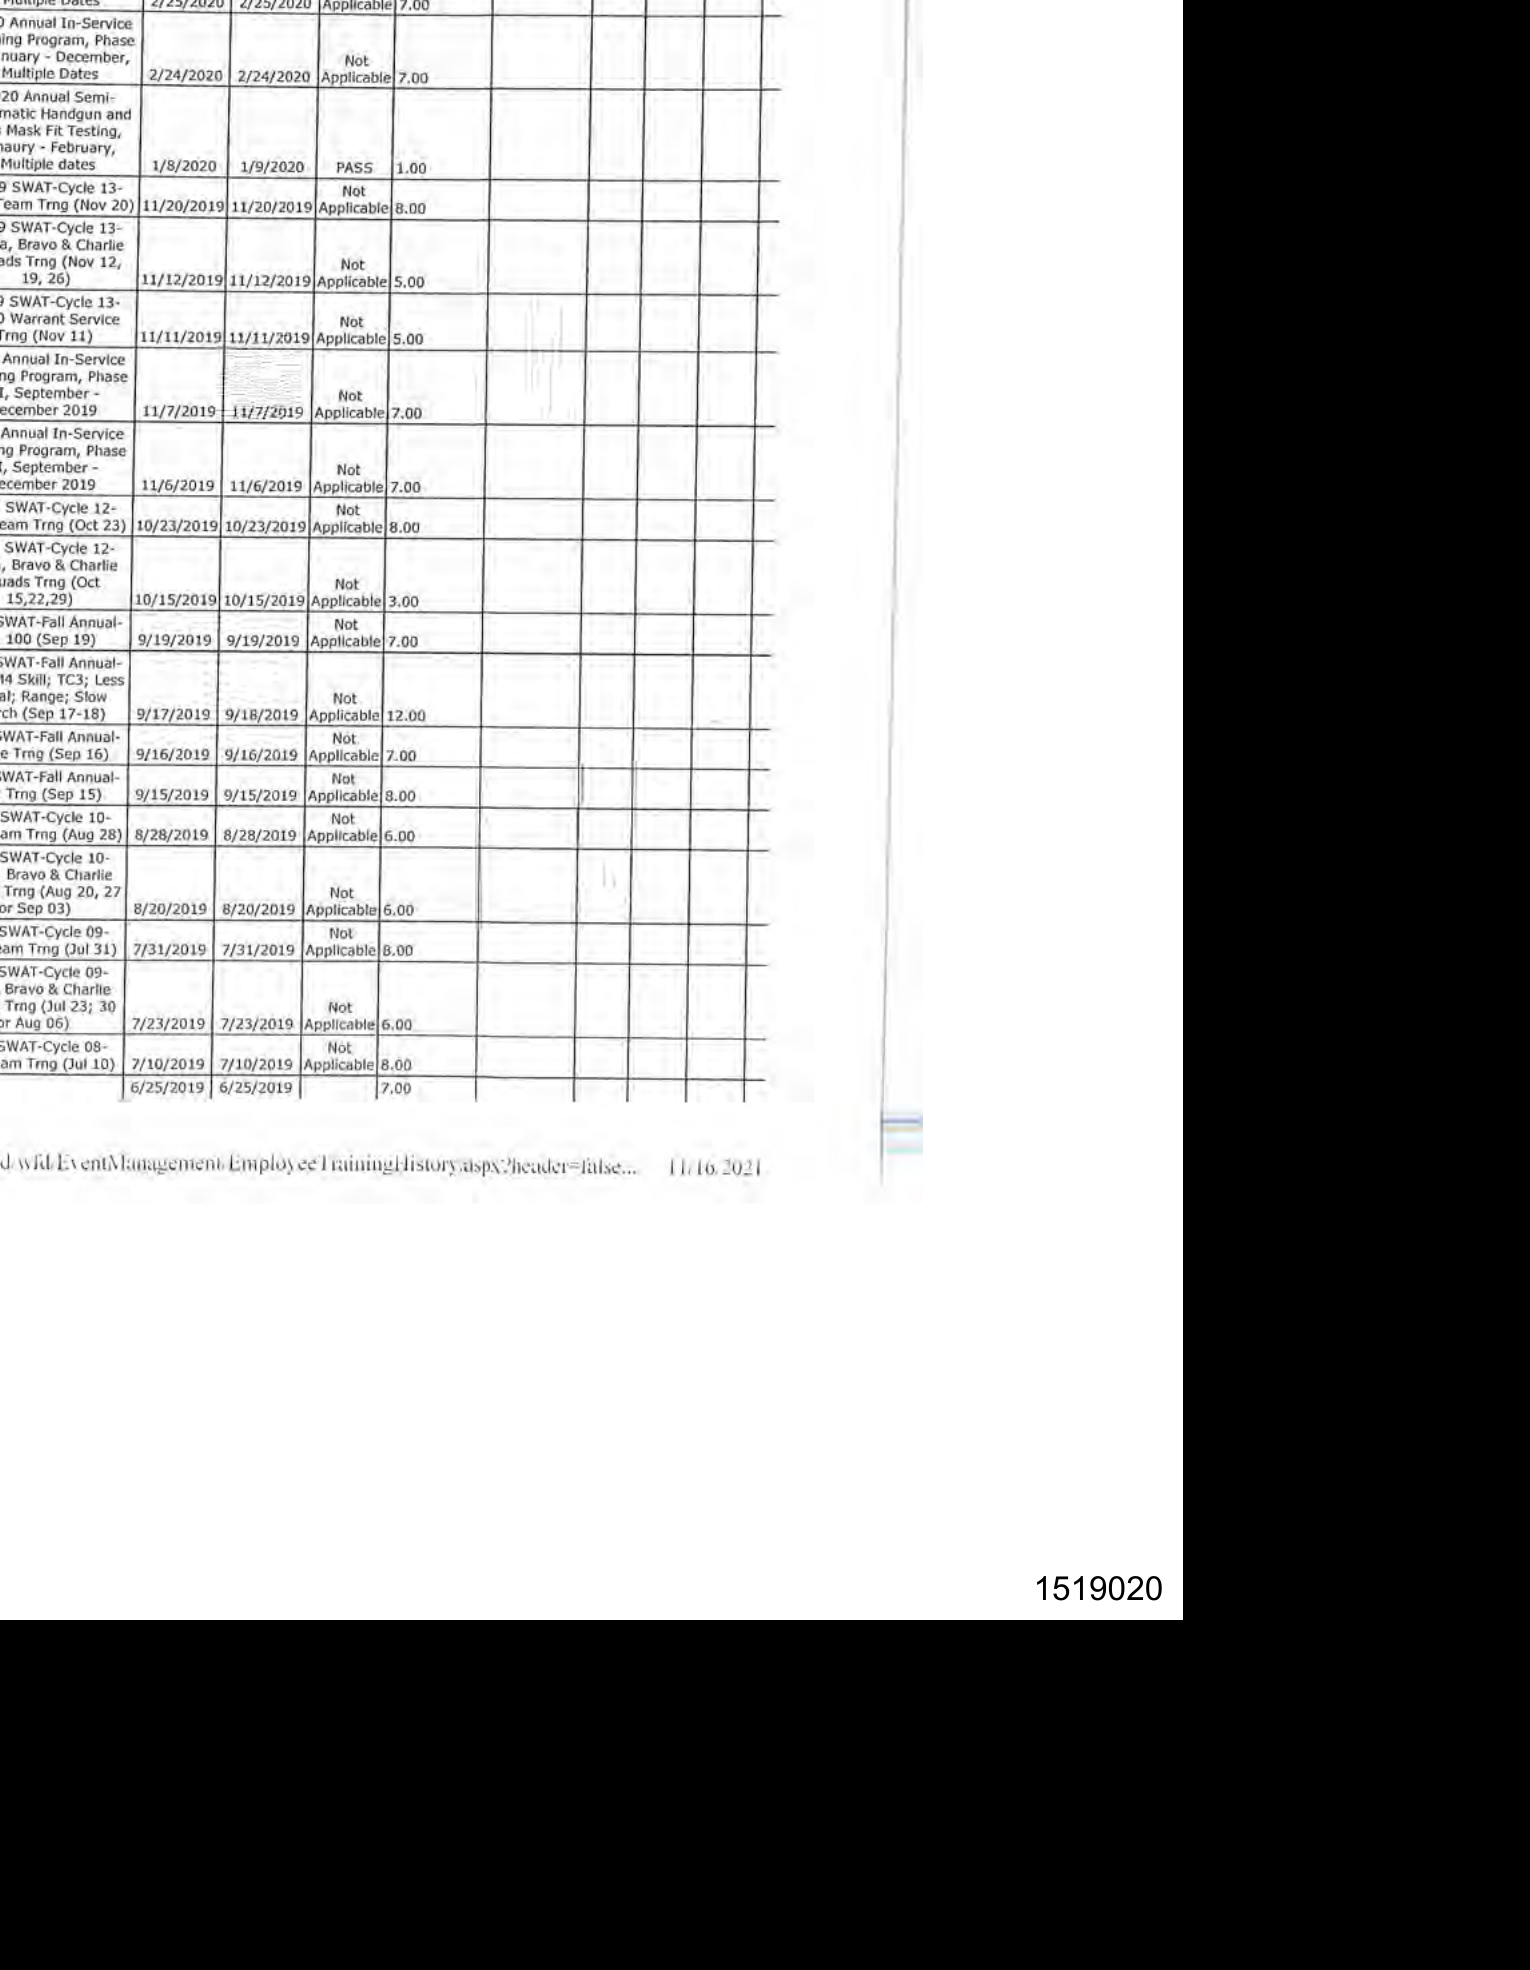

In [59]:
#Preprocessing: cropping
#Let's try cropping the image

#pages = convert_from_path('Redacted_.pdf', dpi=300)
pages=doc
page_image = pages[6] 

crop_box = (470, 630, 2000, 2600)
cropped_table = page_image.crop(crop_box)
display(cropped_table)

In [ ]:
import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from IPython.display import display

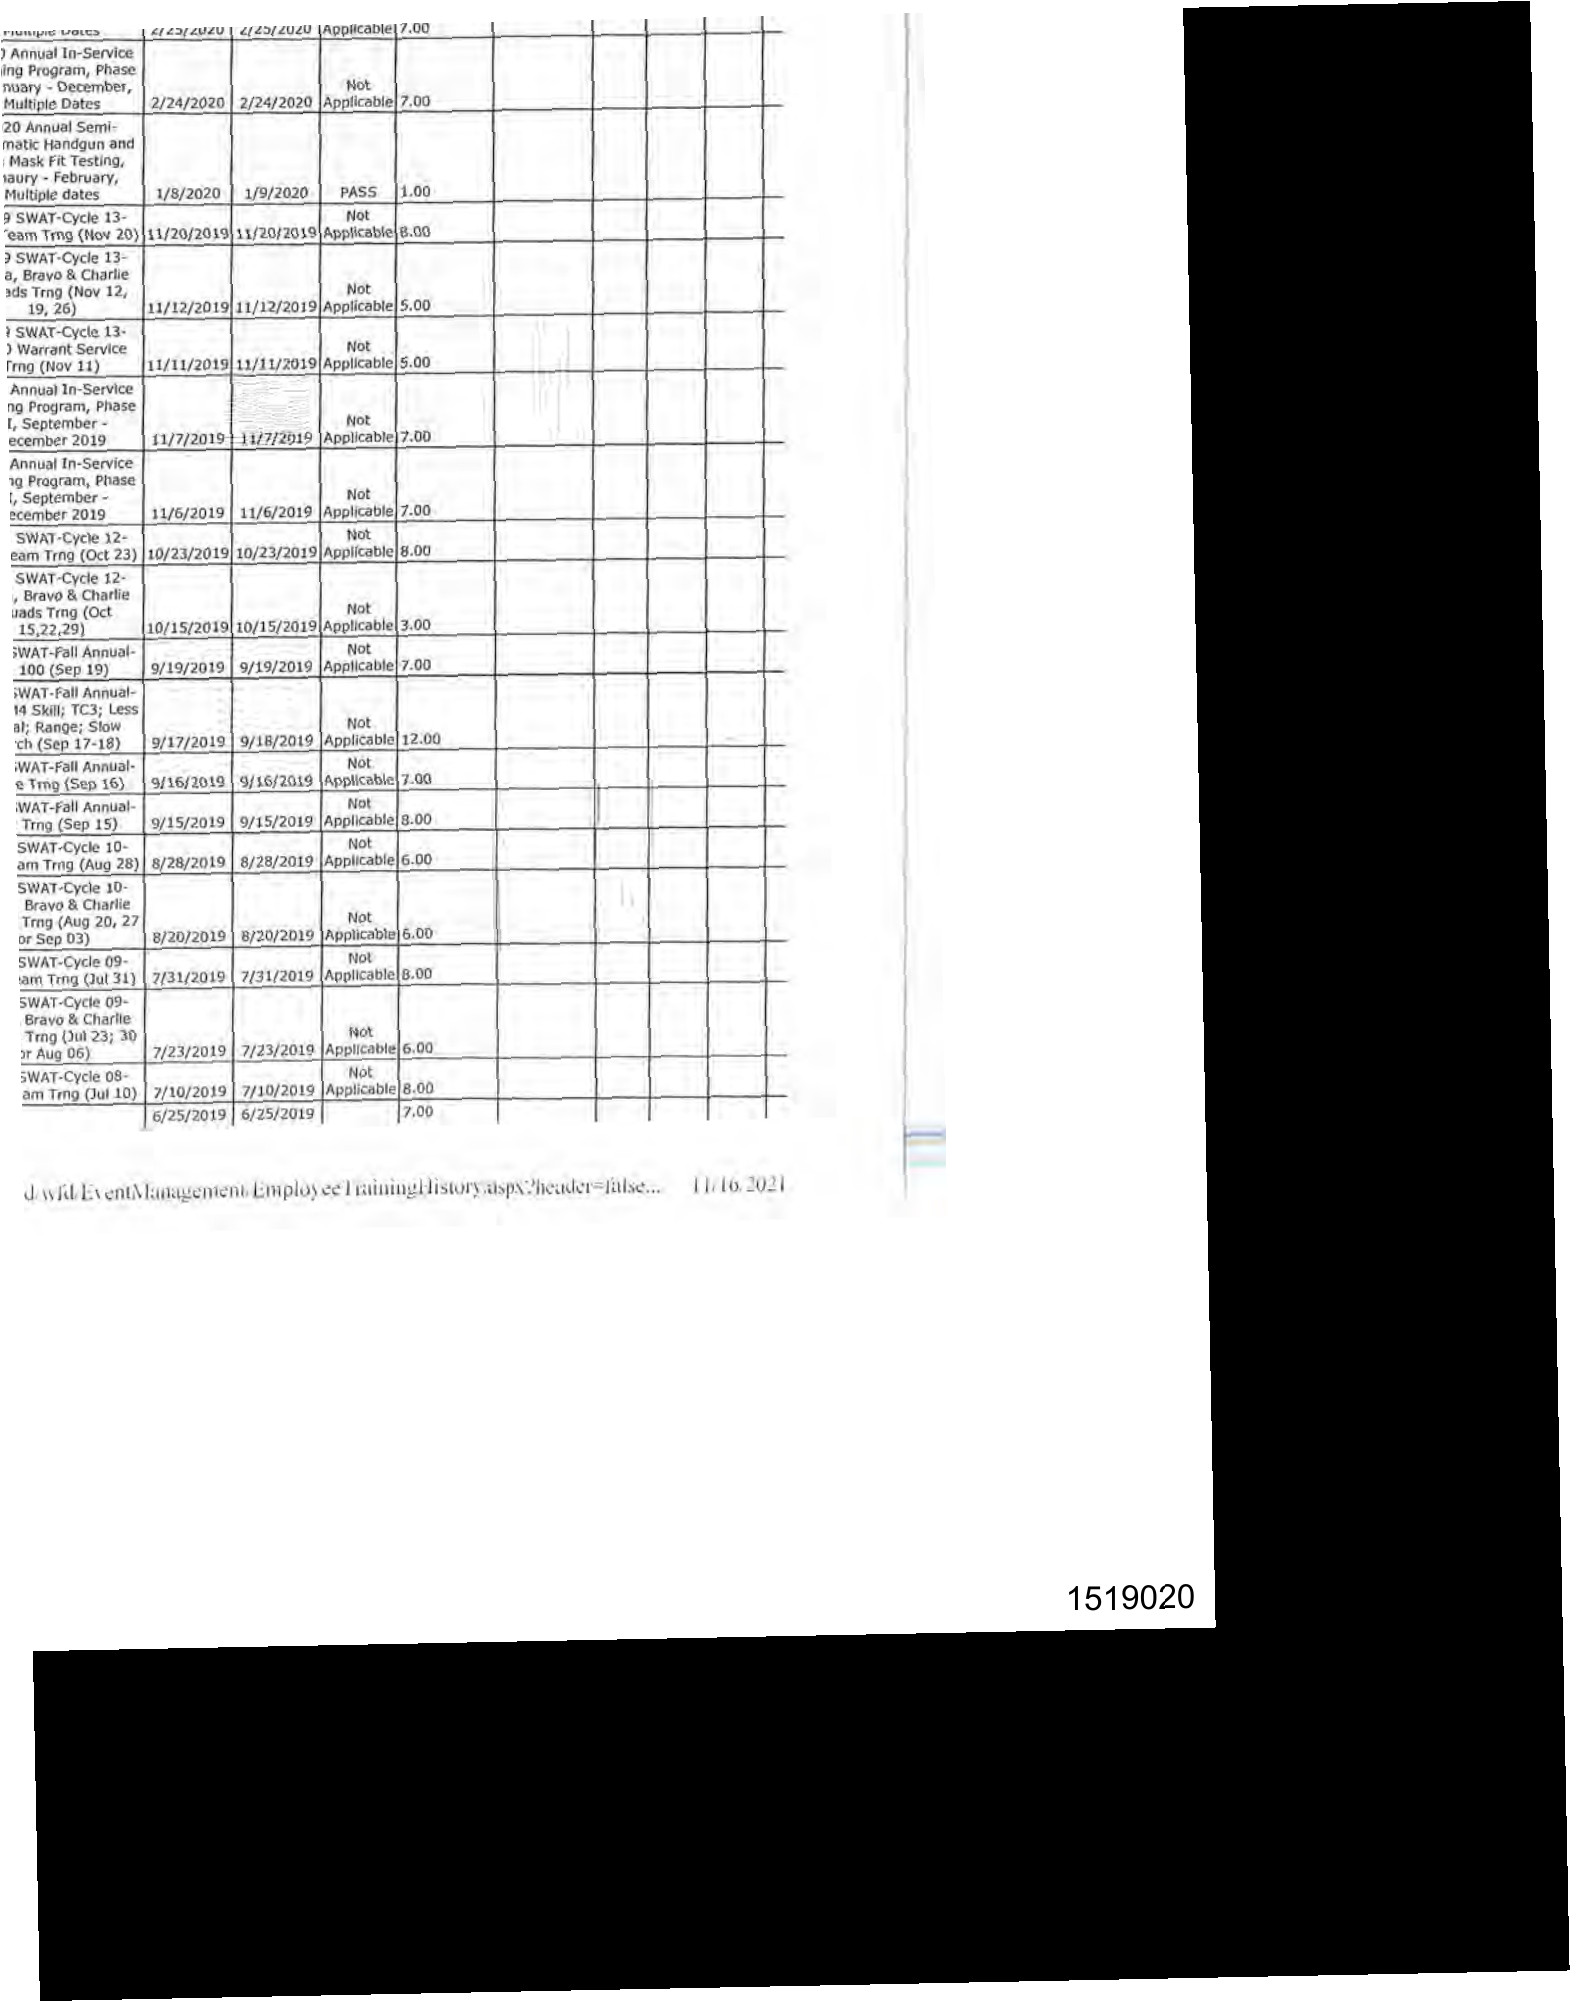

In [60]:
#Preprocessing: rotation
cropped=cropped_table
rotated = cropped.rotate(1.15, expand=True, fillcolor='white')

# Display in notebook
display(rotated)

In [58]:
text = pytesseract.image_to_string(rotated)

# Display image and OCR output
#display(rotated)
print(text)

WorkForce Director

2019 SWAT-Cycle 08-
Alpha, Bravo, Charlie,
Delta Squads Trng (Jun
25; Ju! 02, 09, 16)

2019 SWAT-Cycle 08-

Not
Edit|Delete] 1280 Trng (Jun 24) | 6/24/2019 | 6/24/2019 |Applicable|4.00
2019 Annual In-Service
Training Program, Phase Not
Edit] Delete] 11, (Apr-Aug/Sep 25-26) | 6/11/2019 | 6/11/2019 |Applicable| 7.00
2019 Annual In-Service
Training Program, Phase Not
Edit] Delete] J, (Apr-Aug/Sep 25-26) | 6/10/2019 | 6/10/2019 Applicable] 7.00
2019 SWAT-Cycle 07-
Rifle Team Trng (Jun 0S- Not
Edit 06) 6/5/2019 | 6/6/2019 |Applicable| 16,00
2019 SWAT-Cycle 07-

Alpha, Bravo,Charlie,Delta|
Squads Trng (May 28,
Jun 04, 11, $8)

2019 SWAT-Cycle 06-

Not
Edit| Delete} 5/28/2019 | 5/28/2019 |Applicable| 6.00

Not
Edit|Delete|Rifle Team Trng (May 08)| $/8/2019 | 5/8/2019 [Applicable] 8.00
2019 SWAT-Cycle 06-
‘Squads-7 Hr
Breaching/Tools Re-Cert

| ena |

(Apr 30; May 07, 14 or Not
Edit Delete} 23) 5/7/2039} 5/7/2019 Applicable} 7.00
2019 SWAT-Cycle 06-

Squads-7 Hr
Breaching/T

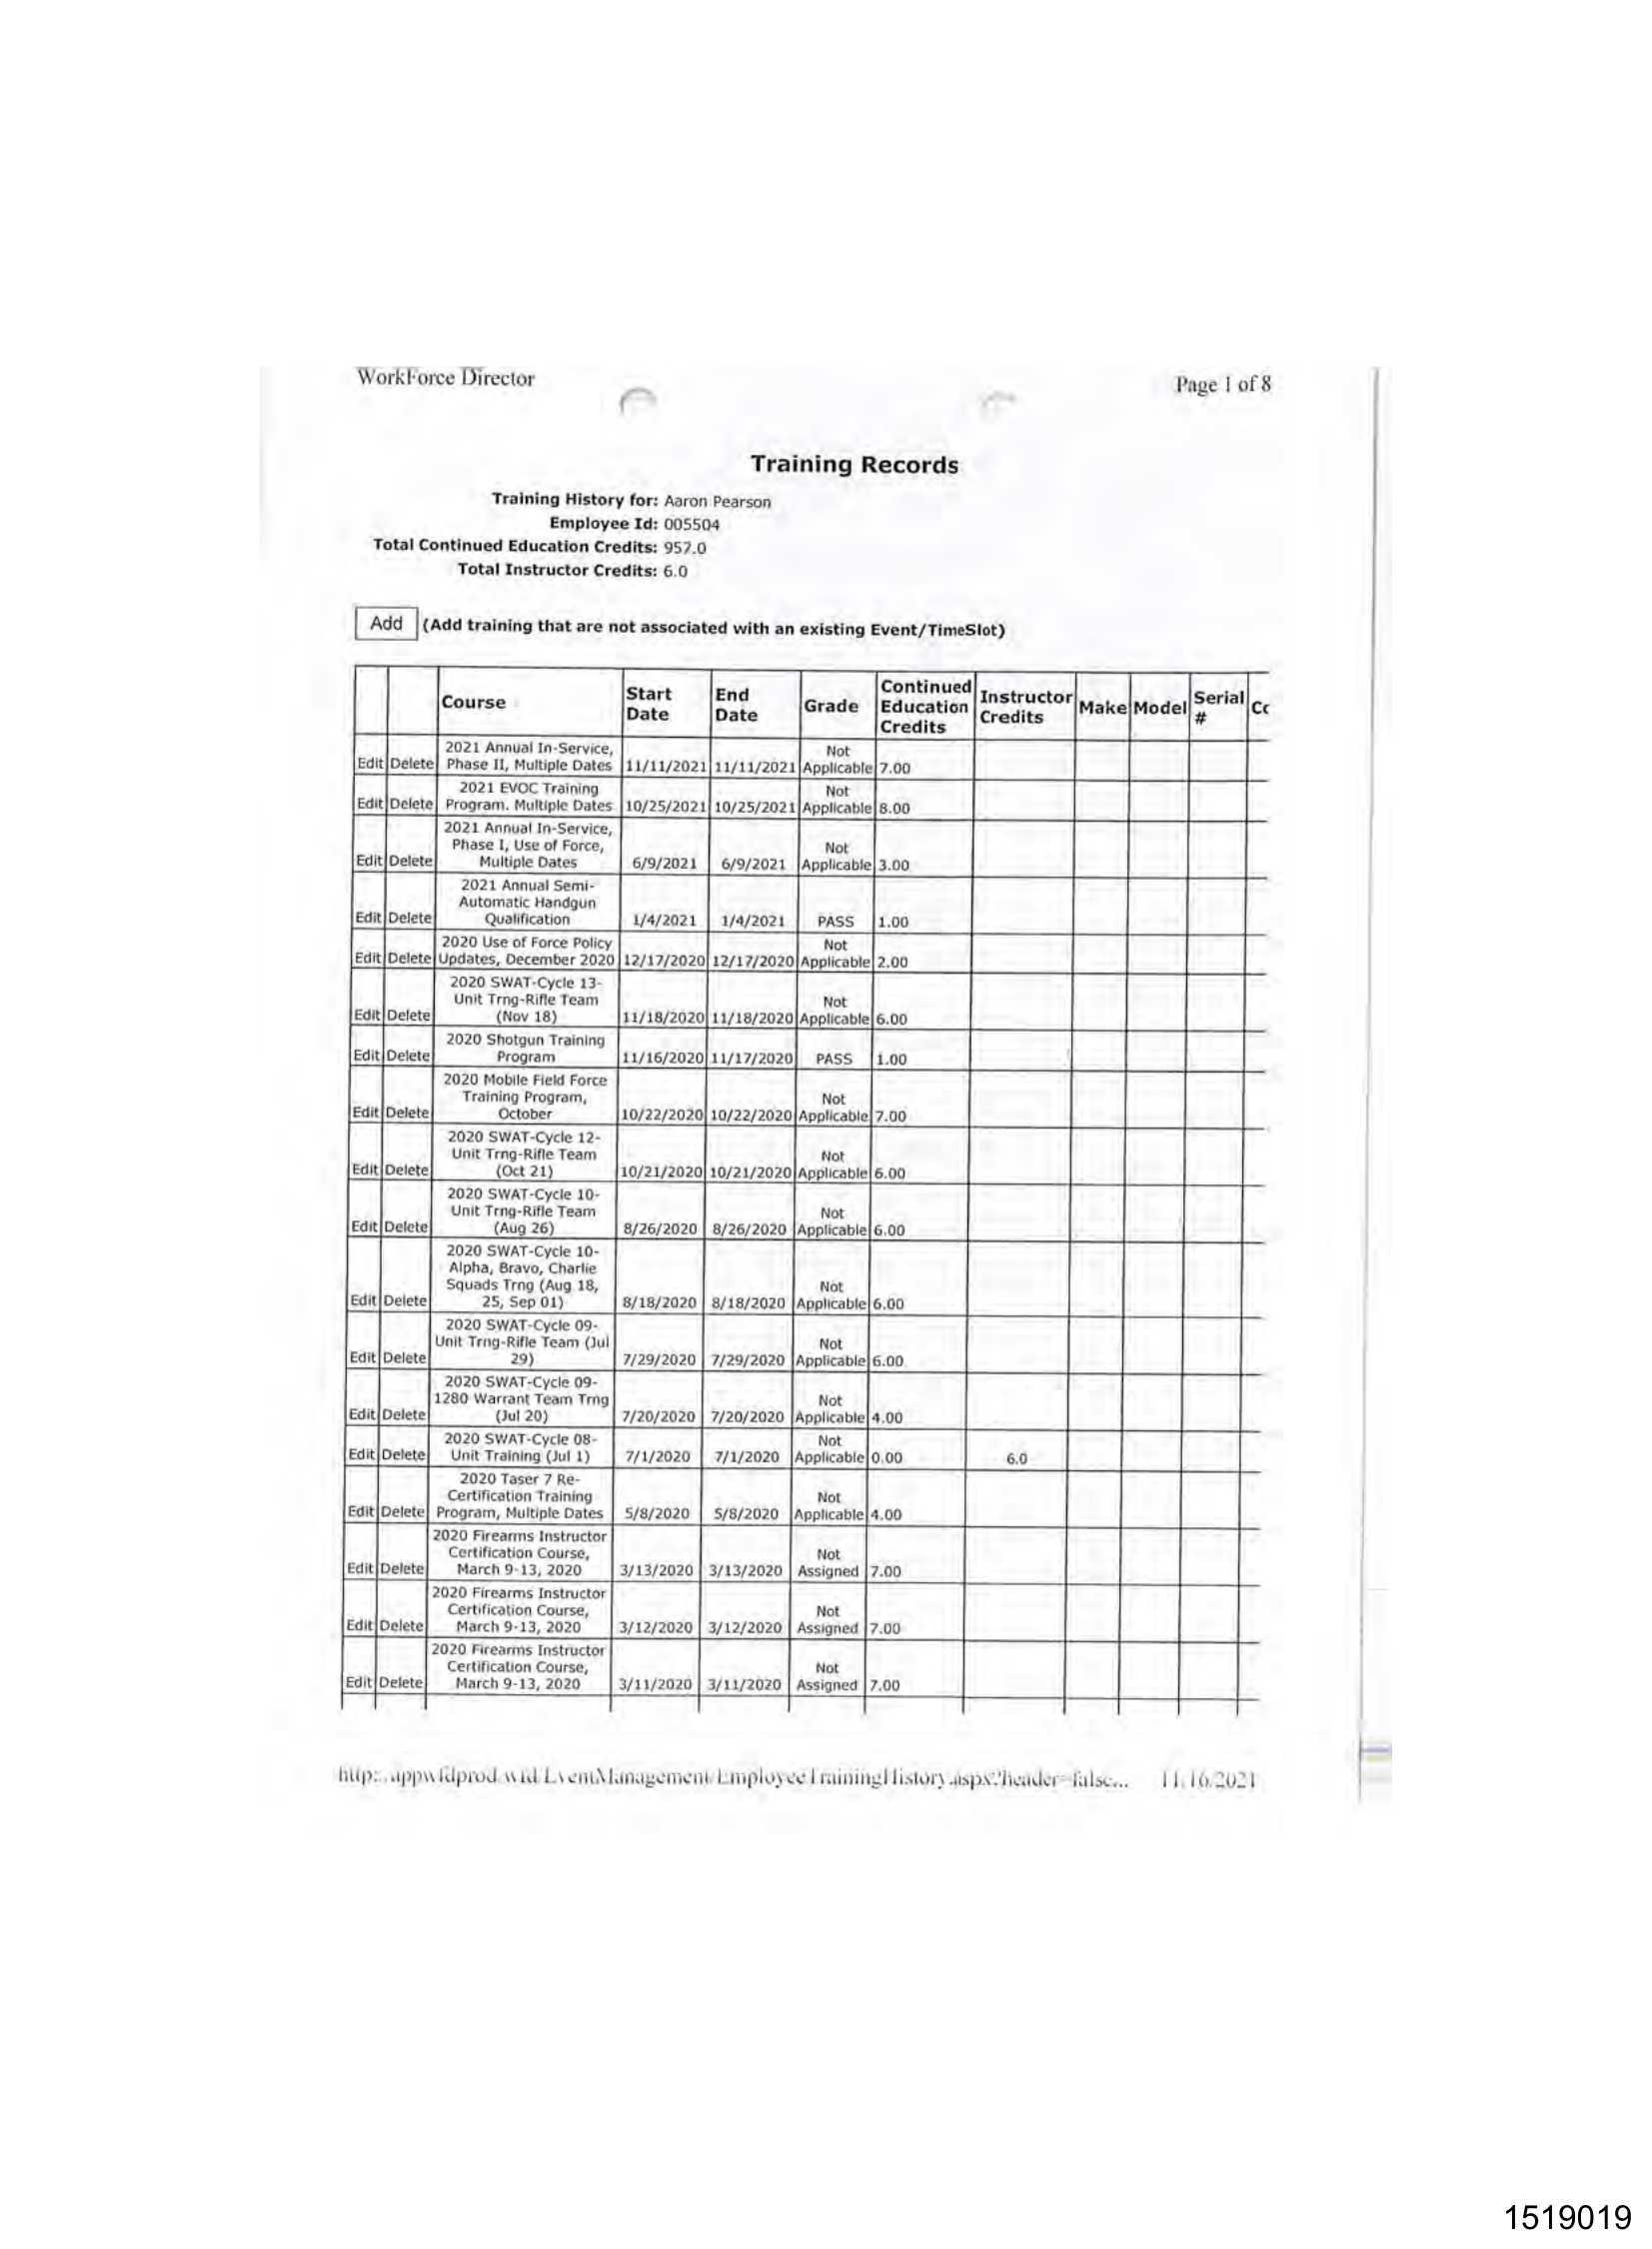

In [62]:
display(pages[5])

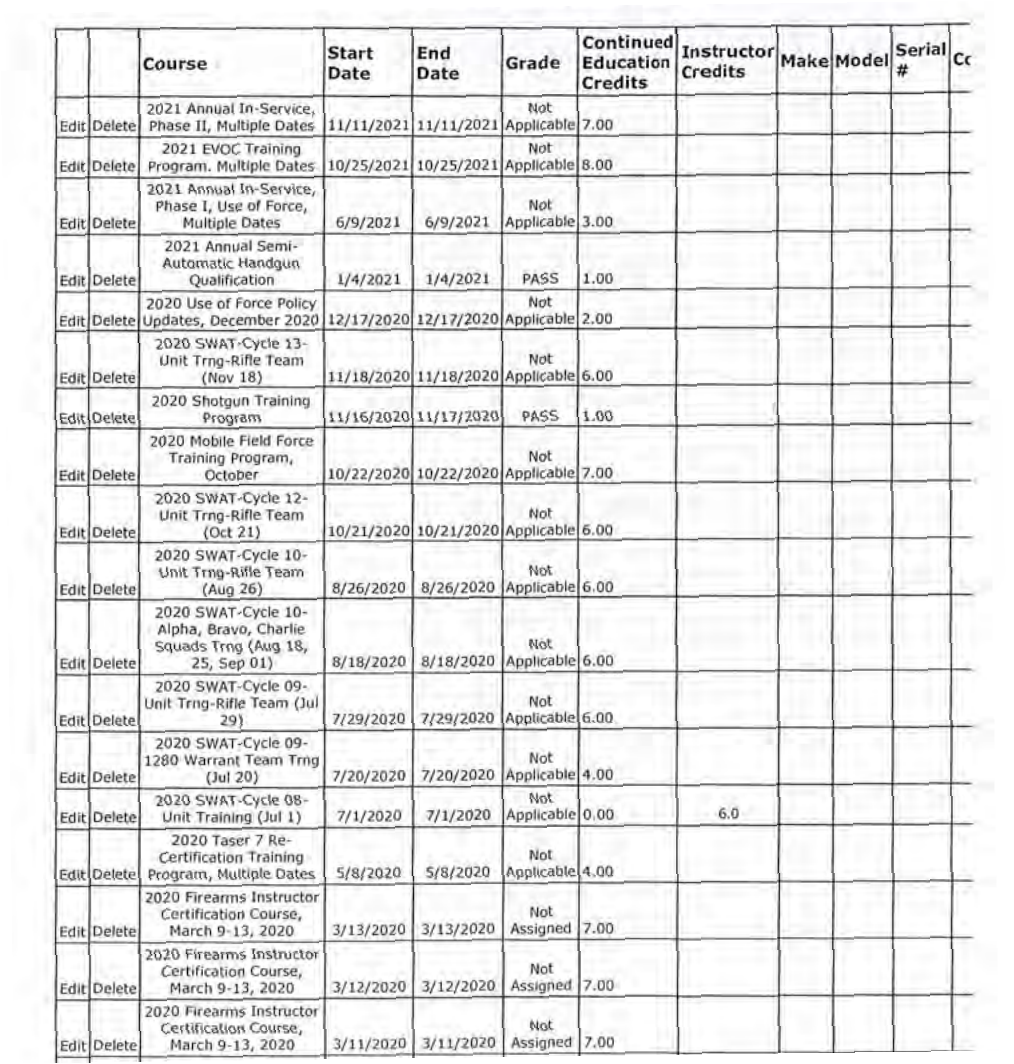

In [77]:
#Let's try page 5, the first page
page_image = pages[5] 

crop_box = (300, 650, 1300, 1700)
cropped_table = page_image.crop(crop_box)
cropped=cropped_table
rotated = cropped.rotate(.75,expand=True, fillcolor='white')

display(rotated)

In [78]:
text = pytesseract.image_to_string(rotated)

# Display image and OCR output
#display(rotated)
print(text)

2021 ev0C Training
Program. Multiple Dates

2024 Annual In-Service,
Phase I, Use of Force,
Multiple Dates 6/9/2021

2021 Annyal Semi-
Automatic Handgun
Qualification 1/4/2021

2020 Use of Force Policy
Updates, December 2020.

2020 SWAT-Cycle 13-
Unit Trng-Rifle Team

(Nov 18)
2020 Shotgun Training

Program 11/16/2020] 11/17/2020) PASS.
2020 Mobile Field Force

Training Program,

October 10/22/2020] 10/22/2020}

2020 SWAT-Cycle 22- \

Unit Trng-Rifle Team

+

(Oct 21) 10/21/2020] 10/21/2020)

2020 SWAT-Cycle 10-
‘Unit Trng-Rifle Team

(Aug 26)

8/26/2020 | 8/26/2020

2020 SWAT-Cycle 10-
Alpha, Bravo, Charlie

25, Sep 01) 8/18/2020
2020 SWAT-Cycle 09-
Unit Teng-Rifle Team (Jul
7/29/2020

2020 SWAT-Cycle 09-
1280 Warrant Team Trn

9
(Qui 20) 7/20/2020

‘Squads Trng (Aug 18,

2020 SWAT-Cycle 08~
Unit Training (Jul 1) | 7/1/2020

Delete} Program, Multiple Oates

2020 Taser 7 Re-
Certification Training

5/8/2020

2020 Firearms Instructor
Certification Course,

March 9-13, 2020 __| 3/13/2020


In [84]:
import cv2

In [ ]:
#This code is pretty good, but let's add an overlay

#We grayscale the image
import numpy as np
gray = np.array(rotated.convert("L"))


In [85]:
#We binarize the data, converting dark gray into black and light gray into white

binary = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    15, 10
)


In [ ]:
#We add verticle and horizontal masks to detect those lines

#Kernels to pick out long horizontal or vertical strokes
horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
vert_kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

horiz = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horiz_kernel)
vert  = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vert_kernel)

In [ ]:
#Merge horizontal and vertical into full grid mask
grid = cv2.add(horiz, vert)

#Detect all contours in that grid
contours, _ = cv2.findContours(grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
#Draw boxes on a color preview
preview = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if 50 < w < gray.shape[1] and 20 < h < gray.shape[0]:
        cv2.rectangle(preview, (x, y), (x+w, y+h), (0, 255, 0), 2)

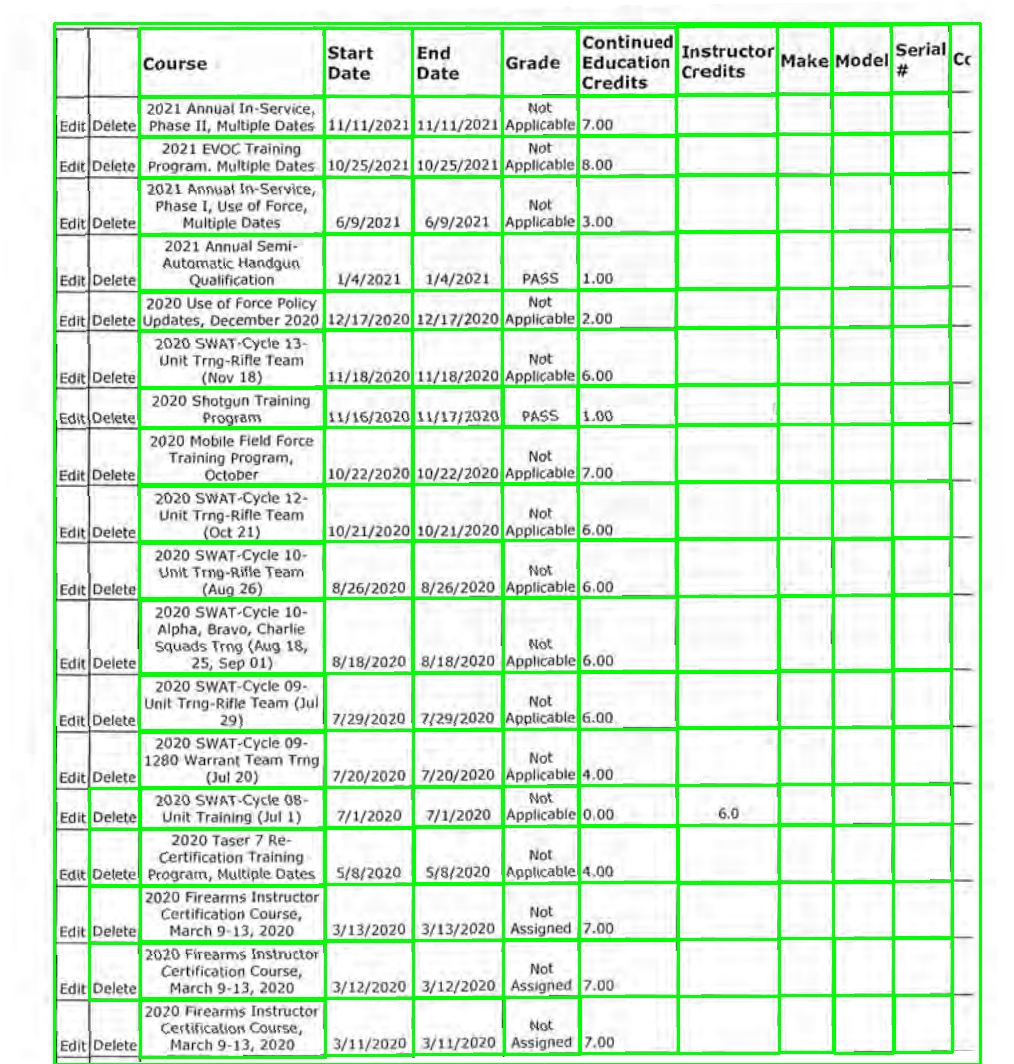

In [89]:
display(Image.fromarray(preview))


In [ ]:
#Save the image here
cv2.imwrite("preview.png", cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))

True